In [2]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5,amsgrad=True)
from time import time


In [3]:
X = np.linspace(0,2,20)[:,None]
Xlocs = X.copy()
X = np.c_[X,np.zeros(X.shape[0])]
X = np.r_[X,X]
#X[:int(len(X)/2),0]*=2
X[int(len(X)/2):,1]=1

y = 10*(1+np.cos(Xlocs/2))
realy = y.copy()
y[6:]*=1.5 #simulate low-cost sensor bias
X = tf.Variable(X,dtype=tf.float32)
Z = np.linspace(0,2,5)[:,None]
Z = np.r_[Z,Z]
Z = np.c_[Z,np.zeros(Z.shape[0])]
Z[int(len(Z)/2):,1]=1
Z = tf.Variable(Z,dtype=tf.float32)
y = tf.Variable(y,dtype=tf.float32)
m = Z.shape[0]


In [287]:
def K(X1,X2):
    return 1000.0*tf.cast(tf.math.equal(X1[:,-1,None],X2[None,:,-1]),tf.float32)*tf.exp(-tf.math.reduce_sum(tf.subtract(X1[:,None],X2[None,:])**2/(2*2**2),2)) 

In [288]:
#definition of q(u)
mu = tf.Variable(0*tf.random.normal([m]))#, name='mu')
scale = tf.Variable(0.5*tf.random.normal([m, m]))#, name='scale')
#scale = tf.Variable(tf.eye(m))#, name='scale')

#parameters for p(u)
mu_u = tf.zeros([m])
cov_u = tf.Variable(K(Z,Z))

pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*0.1)
Kzz = K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.1


In [289]:
def combine_sensor_latent(sens,lat):
    #return lat/(1+sens/100) #tf.exp(sens/10)#(1+sens)
    #return tf.concat([lat[:,:6],lat[:,6:]/(1+sens[:,6:]/100)],axis=1)
    return tf.concat([lat[:,:6],lat[:,6:]/tf.exp(sens[:,6:]/10)],axis=1)
    #return tf.concat([lat[:,:6],lat[:,6:]+sens[:,6:]],axis=1)
    #return lat

In [290]:
import time
alltimes = []
old_elbo_loss = -np.inf
optimizer.learning_rate = 0.2
for it in range(1000):
    with tf.GradientTape() as tape:
        qu = tfd.MultivariateNormalTriL(mu,scale)
        qf_mu = K(X,Z) @ tf.linalg.solve(Kzz , mu[:,None])        
        qf_cov = K(X,X) - K(X,Z) @ tf.linalg.solve(Kzz , K(Z,X)) + K(X,Z)@ tf.linalg.solve(Kzz,(scale@tf.transpose(scale))) @ tf.linalg.solve(Kzz ,K(Z,X))
        
        N = int(X.shape[0]/2)
        batched_mu = tf.transpose(tf.reshape(qf_mu,[2,N]))
        batched_cov = [[tf.linalg.diag_part(qf_cov[:N,:N]),tf.linalg.diag_part(qf_cov[N:,:N])],[tf.linalg.diag_part(qf_cov[:N,N:]),tf.linalg.diag_part(qf_cov[N:,N:])]]
        samps = tfd.MultivariateNormalFullCovariance(batched_mu,tf.transpose(batched_cov)).sample(100)
        f = combine_sensor_latent(samps[:,:,1],samps[:,:,0])
        
        lls = tfd.Normal(f,0.01).log_prob(y[:,0])
        #ell = tf.math.reduce_sum(tf.math.reduce_mean(lls,axis=0))
        ell = tf.math.reduce_sum(tfp.stats.percentile(tf.math.reduce_mean(tf.reshape(lls,[10,10,20]),axis=0),50.0,axis=0))
        elbo_loss = -ell+tfd.kl_divergence(qu,pu)
    gradients = tape.gradient(elbo_loss, [mu, scale])

    if elbo_loss<old_elbo_loss:
        optimizer.learning_rate=optimizer.learning_rate*1.02
    else:
        #print(optimizer.learning_rate.numpy())
        optimizer.learning_rate=optimizer.learning_rate/1.1
        #continue #try again
    if optimizer.learning_rate>0.4: optimizer.learning_rate=0.4
        
    optimizer.apply_gradients(zip(gradients, [mu, scale]))
    if it%20 == 0: print(elbo_loss.numpy(),optimizer.learning_rate.numpy())
    if not np.any(np.linalg.eigvals(scale.numpy())<1e-6):
        print("uhoh")
    old_elbo_loss=elbo_loss

61391924.0 0.18181819
2391632.5 0.1912767
696363.8 0.12697418
106051.086 0.11905489
57105.83 0.088673405
47253.703 0.052463077
48948.28 0.019585866
45589.26 0.010327861
44714.723 0.0038556657
47420.71 0.0016150322
47700.06 0.001072098
44804.1 0.00044907242


KeyboardInterrupt: 

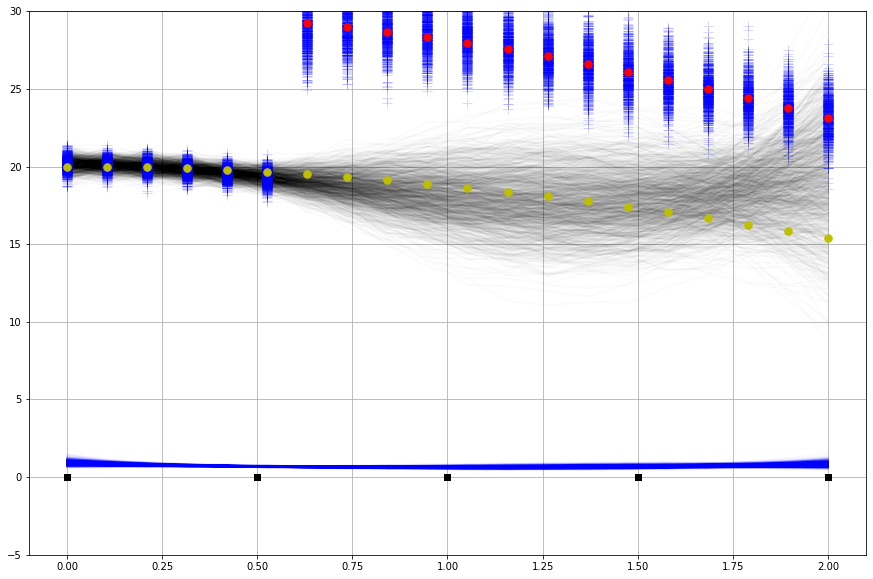

In [291]:
plt.figure(figsize=[15,10])
qf = tfd.MultivariateNormalFullCovariance(qf_mu[:,0],qf_cov+np.eye(qf_cov.shape[0])*0.1)
samps = qf.sample([1000]).numpy()

Xn = X.numpy()
plt.plot(Xn[Xn[:,1]==0,0],samps[:,Xn[:,1]==0].T,'k-',alpha=0.02);
plt.plot(Xn[Xn[:,1]==1,0],tf.exp(samps[:,Xn[:,1]==1].T/10),'b-',alpha=0.02);
plt.plot(Xn[Xn[:,1]==0,0],tf.transpose(combine_sensor_latent(samps[:,Xn[:,1]==1],samps[:,Xn[:,1]==0])),'b+',markersize=10,alpha=0.15);
#plt.plot(Xn[Xn[:,1]==0,0],samps[:,Xn[:,1]==1].T,'bx',alpha=0.05);
plt.ylim([-5,30])
plt.plot(Xlocs,realy,'.y',markersize=15)
plt.plot(Xlocs[6:,:],y.numpy()[6:],'.r',markersize=15)
#Xstar = np.linspace(-5,15,1000)[:,None]
#invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)

#mean = (K(Xstar,Z) @ invKzz @ mu.numpy()[:,None]).numpy()[:,0]
#cov = K(Xstar,Xstar) - K(Xstar,Z) @ np.linalg.inv(K(Z,Z)) @ K(Z,Xstar)
#stds = np.sqrt(np.diag(cov))

#plt.plot(Xstar,mean,'r-',lw=3);
#plt.plot(Xstar,mean+stds,'r-',lw=1);
#plt.plot(Xstar,mean-stds,'r-',lw=1);
plt.grid()
plt.plot(Z.numpy()[:,0],np.zeros_like(Z.numpy()),'ks')

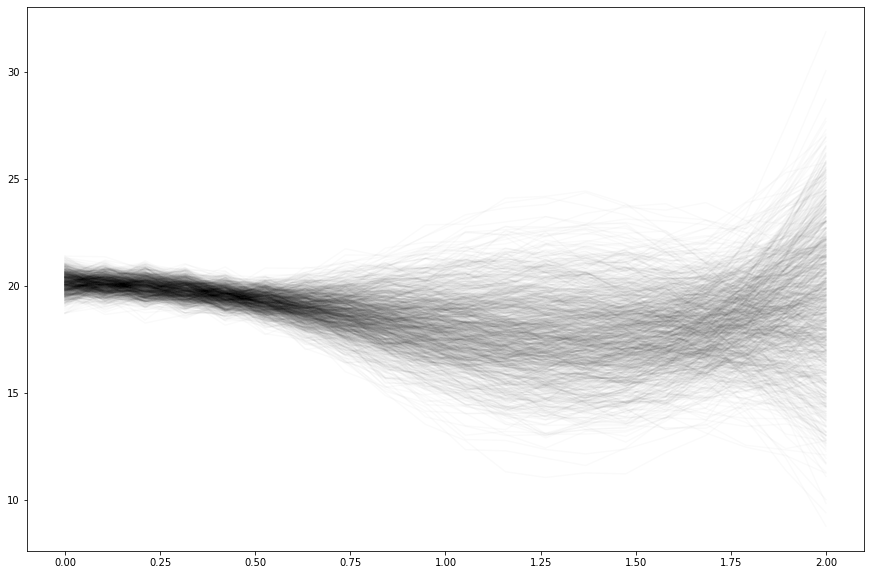

In [292]:
plt.figure(figsize=[15,10])
#plt.plot(Xn[Xn[:,1]==0,0],(samps[:,Xn[:,1]==0]-np.mean(samps[:,Xn[:,1]==0],0)).T,'k-',alpha=0.1);
plt.plot(Xn[Xn[:,1]==0,0],(samps[:,Xn[:,1]==0]).T,'k-',alpha=0.02);
#plt.ylim([-300,300])

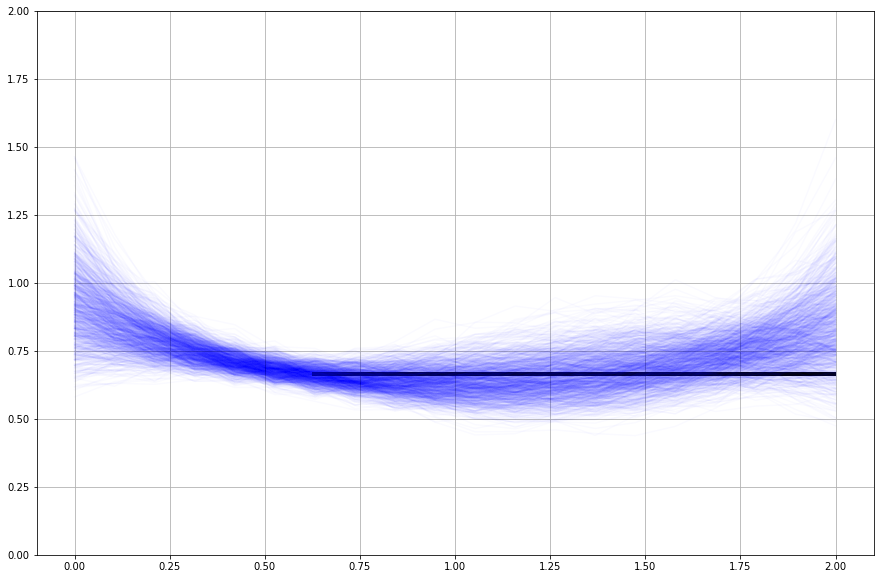

In [293]:
plt.figure(figsize=[15,10])
#plt.plot(Xn[Xn[:,1]==0,0],(samps[:,Xn[:,1]==0]-np.mean(samps[:,Xn[:,1]==0],0)).T,'k-',alpha=0.1);
plt.plot(Xn[Xn[:,1]==1,0],np.exp(samps[:,Xn[:,1]==1]/10).T,'b-',alpha=0.02);
#plt.plot(Xn[Xn[:,1]==1,0],(samps[:,Xn[:,1]==1]).T,'b-',alpha=0.02);
plt.ylim([0,2])
plt.grid()
plt.hlines(1/1.5,1.25/2,2,color='k',lw=4)

0.6666666666666666

In [257]:
samps.shape

(1000, 20)

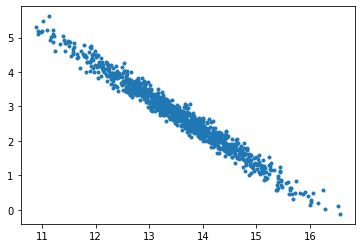

In [258]:
plt.plot(samps[:,8],samps[:,8+10],'.');

In [60]:
b

<tf.Tensor: id=47954, shape=(2, 2), dtype=float32, numpy=
array([[ 4.499, -0.731],
       [-0.731,  3.24 ]], dtype=float32)>

In [853]:
x = tf.Variable(tf.random.normal([2,2]))#, name='scale')
#x=tf.transpose(x)@x
with tf.GradientTape() as tape:
    y = x*2
tape.gradient(y,[x])

[<tf.Tensor: id=27553075, shape=(2, 2), dtype=float32, numpy=
 array([[2., 2.],
        [2., 2.]], dtype=float32)>]

In [922]:
def like(x,y):
    f = x/(1+y)
    #f = tf.where(tf.greater(f, 10), 10*tf.ones_like(f,dtype=np.float32), f)
    #f = tf.where(tf.less(f, -10), -10*tf.ones_like(f,dtype=np.float32), f)
    return f

X = np.linspace(-10,10,60)
Y = np.linspace(-10,10,60)
p = []
v = []
for i,x in enumerate(X):
    for j,y in enumerate(Y):
        p.append([x,y])
        v.append(tfd.Normal(tf.Variable(like(x,y),dtype=np.float32),0.1).log_prob(1))
p=np.array(p)
v=np.array(v)

In [932]:
a = tf.Variable(1*tf.random.normal([2]))#, name='mu')
b = tf.Variable(3*tf.random.normal([2,2]))#, name='scale')

[<tf.Tensor: id=30509788, shape=(2,), dtype=float32, numpy=array([-1.765,  1.836], dtype=float32)>, <tf.Tensor: id=30509847, shape=(2, 2), dtype=float32, numpy=
array([[ 0.809, -0.868],
       [ 0.795, -0.805]], dtype=float32)>] 
 [ 0.325 -0.585] 
 [[2.588 2.665]
 [3.391 3.29 ]]


/home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(-10, 10)

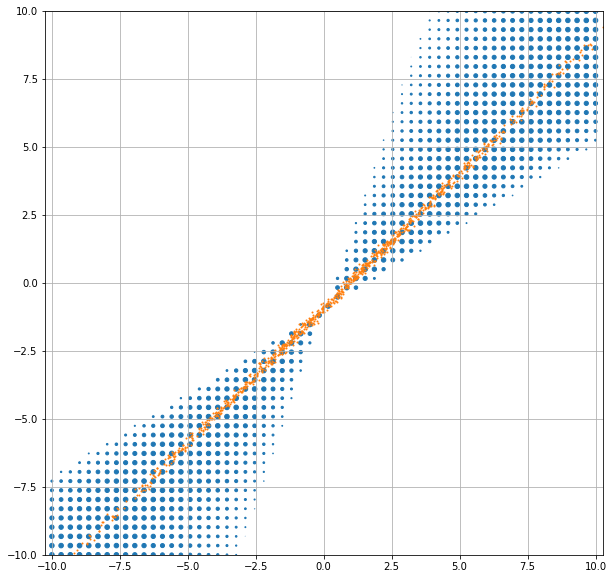

In [934]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
for it in range(100):
    with tf.GradientTape() as tape:
        try:
            dist = tfd.MultivariateNormalFullCovariance(a,tf.transpose(b)@b)
        except Exception:
            print("FAILED!")
            #b=b+tf.eye(2)*0.1
            break
        samps = dist.sample(10000)
        f = like(samps[:,0],samps[:,1])
        #f = samps[:,0]/tf.exp(samps[:,1])
        lls = tfd.Normal(f,0.1).log_prob(1)
        #ell=-tf.math.reduce_mean(lls)
        ell = -tfp.stats.percentile(lls, 50.0)
        
        ell=ell-tf.linalg.det(b)*0.01
        #ell = tf.math.reduce_mean(b)
    gradients = tape.gradient(ell, [a,b])
    optimizer.apply_gradients(zip(gradients, [a,b]))
    #b=b+gradients[1].numpy()
    #plt.hist(f,100,range=[-4,4]);
    #plt.grid()
print(gradients,'\n',a.numpy(),'\n',b.numpy())
dist = tfd.MultivariateNormalFullCovariance(a,tf.transpose(b)@b)
samps = dist.sample(1000)
plt.figure(figsize=[10,10])
plt.scatter(p[:,0],p[:,1],20+v)
plt.scatter(samps[:,0],samps[:,1],1);
plt.grid()
plt.axis('equal')
plt.xlim([-10,10])
plt.ylim([-10,10])

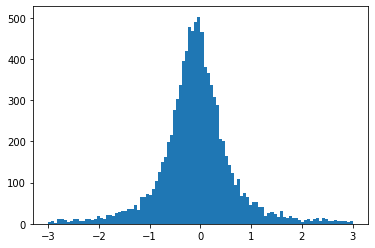

In [665]:
plt.hist(f,100,range=[-3,3]);

/home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


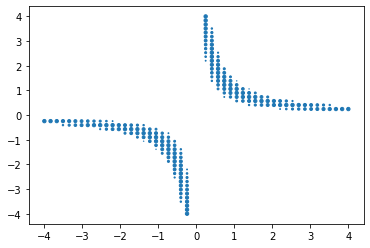

In [789]:
with tf.GradientTape() as tape:
    testmean = tf.Variable(0.1)
    samples = tfd.Normal(testmean,0.1).sample(3)
    result = tf.math.reduce_mean(samples)
gradients = tape.gradient(result,)
#.log_prob(1))

<tf.Tensor: id=12693132, shape=(3,), dtype=float32, numpy=array([-0.029,  0.146,  0.191], dtype=float32)>